In [1]:
import json
import os
import difflib
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
def read_json(fpath: str):
    with open(fpath, "r") as f:
        data = json.load(f)
        f.close()
    return data

root_output_path = "../data/output/"
uwm_data = read_json(os.path.join(root_output_path, "data_uwm_n200.json"))
gumbel_data = read_json(os.path.join(root_output_path, "data_gumbel_n200.json"))
inverse_data = read_json(os.path.join(root_output_path, "data_inverse_n200.json"))

FileNotFoundError: [Errno 2] No such file or directory: '../data/output/data_uwm_n200.json'

In [3]:
# view text differences
def view_text_difference(text1: str, text2: str, text1_title: str = "Without Watermarking", text2_title: str = "With Watermarking"):
    # Tokenize by whitespace
    tokens1 = text1.split()
    tokens2 = text2.split()

    # Sequence matcher
    matcher = difflib.SequenceMatcher(None, tokens1, tokens2)

    html1 = []
    html2 = []

    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            html1.extend(tokens1[i1:i2])
            html2.extend(tokens2[j1:j2])
        elif tag == 'replace':
            html1.extend([f"<span style='color:#fbb;'> {tok} </span>" for tok in tokens1[i1:i2]])
            html2.extend([f"<span style='color:#bfb;'> {tok} </span>" for tok in tokens2[j1:j2]])
        elif tag == 'delete':
            html1.extend([f"<span style='color:#fdd;'> {tok} </span>" for tok in tokens1[i1:i2]])
        elif tag == 'insert':
            html2.extend([f"<span style='color:#dfd;'> {tok} </span>" for tok in tokens2[j1:j2]])

    # Join with spaces
    html1 = " ".join(html1)
    html2 = " ".join(html2)

    # Display side by side
    display(HTML(f"""
    <table style="width:100%; table-layout: fixed; border-collapse: collapse;">
    <tr>
        <th style="border:1px solid black; padding:5px;">{text1_title}</th>
        <th style="border:1px solid black; padding:5px;">{text2_title}</th>
    </tr>
    <tr>
        <td style="border:1px solid black; padding:5px; white-space:pre-wrap; word-wrap:break-word;">{html1}</td>
        <td style="border:1px solid black; padding:5px; white-space:pre-wrap; word-wrap:break-word;">{html2}</td>
    </tr>
    </table>
    """))

In [4]:
sample_index = 50

text1 = uwm_data['data'][sample_index]['output']
text2 = gumbel_data['data'][sample_index]['output']

view_text_difference(text1, text2)

Without Watermarking,With Watermarking


In [4]:
def view_text_highlight(sample_index: int, fname: str):
    dat = read_json(os.path.join("../data/output", fname))

    from transformers import AutoTokenizer
    from IPython.display import display, HTML
    import ftfy

    model_name = "facebook/opt-125m"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    raw_text = ftfy.fix_text(dat['data'][sample_index]['output'])
    encoding = tokenizer(raw_text, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])

    def clean_tokens(tokens):
        cleaned = []
        for token in tokens:
            # Convert token to ID
            try:
                token_id = tokenizer.convert_tokens_to_ids(token)
                text = tokenizer.decode([token_id], clean_up_tokenization_spaces=True)
            except KeyError:
                text = ""  # fallback if token not in vocab

            # Optional: map common special tokens
            if text == "</s>" or text == "<s>":
                text = ""

            cleaned.append(text)
        return cleaned 

    cleaned_tokens = clean_tokens(tokens)

    desc = {
        # "input": ((0, 50), "#d0e1ff", "Input"),
        "unwatermarked0": ((0, 50), "#e0e0e0", "Unwatermarked"),
        "unwatermarked1": ((50, 70), "#e0e0e0", "Unwatermarked"),
        "watermarked": ((70, 100), "#ffd6d6", "Gumbel Watermark"),
        "unwatermarked2": ((100, 150), "#e0e0e0", "Unwatermarked"),
    }

    html_tokens = []
    label_mapper = {}

    for idx, tok in enumerate(cleaned_tokens):
        label = None
        for key, (interval, color, label) in desc.items():
            start, end = interval
            if start <= idx < end:
                label = key
                html_tokens.append(
                    f"<span style='background:{color}; color:black;"
                    f"border-radius:3px; margin:1px;'>{tok}</span>"
                )
                break
            if label not in label_mapper:
                label_mapper[label] = color
            
    legend_html = "".join(
        f"<span style='background:{c}; color:black; padding:2px 5px; border-radius:3px; margin-right:8px;'>{lbl}</span>"
        for lbl, c in label_mapper.items()
    )


    display(HTML(f"""
    <div style="background:white; padding:10px; font-family:monospace; line-height:1.6; font-size:14px;">
        <div style="margin-bottom:8px;">Legend: {legend_html}</div>
    {''.join(html_tokens)}
    </div>
    """))


sample_index = 15
view_text_highlight(sample_index, fname = "data_facebook-opt-125m_n100_gumbel.json")


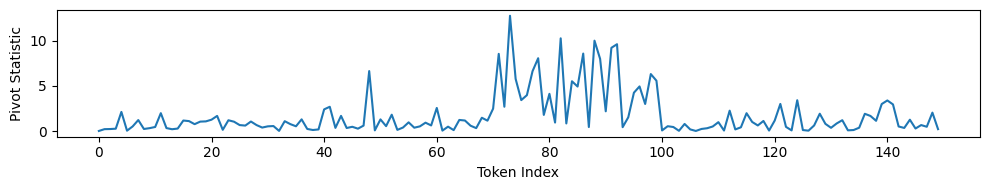

In [5]:
import numpy as np

# generate diagram
sample_index = 40
fname = "data_facebook-opt-125m_n100_gumbel.json"
dat = read_json(os.path.join("../data/output", fname))
pivots = np.concatenate([
    np.random.exponential(scale = 1, size = 50),
    dat['data'][sample_index]['pivots']
])

df = pd.DataFrame({'token_index': range(len(pivots)), 'pivot_statistic': pivots })
plt.figure(figsize=(10, 2))
sns.lineplot(data=df, x='token_index', y='pivot_statistic')
plt.xlabel('Token Index')
plt.ylabel('Pivot Statistic')
plt.tight_layout()
plt.show()

## Diagram

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import pandas as pd

In [ ]:
def read_json(fpath: str):
    with open(fpath, "r") as f:
        data = json.load(f)
        f.close()
    return data

fname = "data_google-gemma-3-270m_n500_gumbel.json"
data = read_json(os.path.join("../data/output", fname))

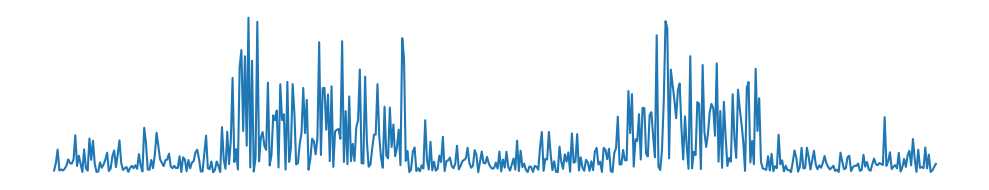

In [10]:
# sample plot for sanity testing
df = []
for sample_index, sample_data in enumerate(data["data"]):
    pivots = sample_data["pivots"]
    for token_index, pivot in enumerate(pivots):
        df.append({
            "sample_index": sample_index,
            "token_index": token_index,
            "pivot_statistic": pivot
        })

df = pd.DataFrame(df)
agg_df = df.groupby(by = ['token_index'])[['pivot_statistic']].mean().reset_index() # plot the pivot statistic

plt.figure(figsize=(10, 2))
ax = sns.lineplot(data=df.loc[df['sample_index'] == 1], # put agg_df in case of agg plot
             # agg_df,
             x='token_index', y='pivot_statistic')

ax.set(xlabel = None, ylabel = None)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Remove the top and right spines
for x in ['top', 'bottom', 'left', 'right']:
    ax.spines[x].set_visible(False)
# sns.despine()

plt.tight_layout()
plt.show()

In [16]:
from time import perf_counter
import numpy as np
import math
from typing import Tuple, List
from watermarking_func import null_distn_gumbel

class SeedBSIntervalResult:
    r: int
    s: int
    tau_hat: int
    S_max: float
    p_tilde: float

    def __init__(self, r, s, tau_hat, S_max, p_tilde):
        self.r = r
        self.s = s
        self.tau_hat = tau_hat
        self.S_max = S_max
        self.p_tilde = p_tilde

class SeedBSNotDetector:

    def __init__(
        self,
        vocab_size: int,
        B = 1000,
        zeta: float = 0.005,
        min_length = 50,
        seed_bs_decay = 2 ** (-0.5),
        B_prime: int = 20,
        T_prime: int = 199
    ):
        self.vocab_size = vocab_size
        self.B = B
        self.min_length = min_length
        self.zeta = zeta
        self.a = seed_bs_decay
        self.B_prime = B_prime
        self.T_prime = T_prime

    def get_num_layers(self, m: int):
        return math.ceil(math.log(m, 1.0 / self.a)) if m > 1 else 1

    def seed_intervals(self, m: int):
        """
        Construct the interval family I used by SeedBS (Algorithm 1).
        Follows the layer-by-layer scheme in the paper:

        - I1 = (0, m]
        - For k = 2, ..., ceil(log_{1/a} m):
            n_k = 2*ceil((1/a)^{k-1}) - 1
            l_k = m * a^{k-1}
            s_k = (m - l_k)/(n_k - 1)
            intervals: ( floor((i-1)*s_k),  ceil((i-1)*s_k + l_k) ], i=1..n_k

        All indices are returned as Python 0-based integers (r, s) representing (r, s].
        Intervals shorter than min_length are dropped.

        Returns a sorted, de-duplicated list of intervals.
        """
        if m < 2:
            return []
        L = self.get_num_layers(m)

        intervals: list[Tuple[int, int]] = []

        # k = 1 layer, I1 = (0, m]
        if m >= self.min_length:
            intervals.append((0, m))

        # k >= 2 layers
        for k in range(2, L+1):
            n_k = int(2 * np.ceil((1 / self.a) ** (k-1)) - 1)
            l_k = int(m * self.a ** (k-1))
            if l_k < self.min_length:
                continue
            if n_k <= 1:
                cand = (0, m)
                if cand[1] - cand[0] >= self.min_length:
                    intervals.append(cand)
                continue

            s_k = (m - l_k) / (n_k - 1)
            for i in range(1, n_k + 1):
                r = int(np.floor((i - 1) * s_k))
                s = int(np.ceil((i - 1) * s_k + l_k))
                r = max(0, min(r, m - 2))
                s = max(r + 1, min(s, m))
                if s - r > self.min_length:
                    intervals.append((r, s))

        # deduplicate and sort (by start, then end)
        intervals = sorted(set(intervals))
        return intervals

    def moving_block_bootstrap_1d(self, x: np.ndarray, B: int):
        """
        Vectorized moving-block bootstrap: returns a resampled array same length as x.
        Equivalent semantics to your previous function but uses numpy indexing only.
        """
        L = x.size
        if L == 0:
            return x.copy()
        B = max(1, min(B, L))
        n_blocks = int(np.ceil(L / B))
        max_start = L - B
        if max_start < 0:
            return x.copy()
        starts = np.random.randint(0, max_start + 1, size=n_blocks)
        block_offsets = np.arange(B) # generate indices for blocks: shape (n_blocks, B)
        indices = (starts[:, None] + block_offsets[None, :]).reshape(-1)
        y = np.take(x, indices, mode='clip')[:L]  # take and truncate to length L
        return y

    def two_sample_ks_distance(self, x: np.ndarray, y: np.ndarray):
        if len(x) == 0 or len(y) == 0:
            return 0
        xs = np.sort(x)
        ys = np.sort(y)
        grid = np.union1d(xs, ys)

        # right-continuous empirical CDFs
        Fx = np.searchsorted(xs, grid, side="right") / xs.size
        Fy = np.searchsorted(ys, grid, side="right") / ys.size
        return float(np.max(np.abs(Fx - Fy)))
    
    def scan_weighted_ks(self, p: np.ndarray, r: int, s: int) -> Tuple[int, float]:
        """
        Compute (τ_hat, max_S) for interval (r, s], using the weighted KS scan statistic:

        S_{r+1:s}(τ) = sup_{t in [0,1]} ((τ - r)*(s - τ) / (s - r)^{3/2}) * |F_{r+1:τ}(t) - F_{τ+1:s}(t)|
        """
        L = s - r
        if L < 2:
            # no valid split
            return (max(r + 1, 1), 0.0)

        best_tau = r + 1
        best_S = -np.inf

        # Iterate tau so that left = p[r:tau], right = p[tau:s] are both non-empty
        for tau in range(r + 1, s):
            left = p[r:tau]
            right = p[tau:s]
            if left.size == 0 or right.size == 0:
                continue

            D = self.two_sample_ks_distance(left, right)  # sup_t |F_left - F_right|
            weight = ((tau - r) * (s - tau)) / ((s - r) ** 1.5)
            S = weight * D

            if S > best_S:
                best_S = S
                best_tau = tau

        return best_tau, float(best_S if best_S > -np.inf else 0.0)

    def bootstrap_p_value_intervals(
        self,
        pvals: np.ndarray,
        r: int,
        s: int,
        B_prime: int,
        T_prime: int
    ):
        """
        Implements the block-bootstrap p-value
        """
        tau_hat, S_max = self.scan_weighted_ks(pvals, r, s)

        # bootstrap resample pvals[r:s] with moving blocks, rescan each
        segment = pvals[r:s]
        if segment.size < 2 or T_prime <= 0:
            return 1.0, tau_hat, S_max
        
        count = 0
        for _ in range(T_prime):
            boot = self.moving_block_bootstrap_1d(segment, B_prime)
            _, S_star = self.scan_weighted_ks(boot, 0, boot.size)
            if S_max <= S_star:
                count += 1

        # add-one correction
        p_tilde = (count + 1) / (T_prime + 1)
        return p_tilde, tau_hat, S_max

    def detect(
        self, 
        pivot_stats: np.ndarray, 
        null_distn
    ):
        # use the null distribution, to figure out the p-values
        null_samples = null_distn((self.B, ), self.vocab_size)
        null_sorted = np.sort(null_samples)
        idx = np.searchsorted(null_sorted, pivot_stats, side="right")  # all things on left is smaller
        pvals = (self.B - idx) / self.B

        # Start timer
        start_time = perf_counter()

        m = pvals.size
        if m < 2:
            return [], perf_counter() - start_time  # no interval deteted
        
        # step 1: seeded intervals (SeedBS)
        intervals = self.seed_intervals(m)

        # step 2: for each interval, compute tau_i, S_max_i, and bootstrap p_i
        results: List[SeedBSIntervalResult] = []
        for (r, s) in intervals:
            p_tilde, tau_hat, S_max = self.bootstrap_p_value_intervals(pvals, r, s, self.B_prime, self.T_prime)
            results.append(SeedBSIntervalResult(
                r = r,
                s = s,
                tau_hat=tau_hat,
                S_max=S_max,
                p_tilde=p_tilde
            ))

        # step 3: Narrowest over threshold (NOT) selection
        over_threshold = [res for res in results if res.p_tilde < self.zeta]
        selected: List[int] = []
        while len(over_threshold) > 0:
            # choose the narrowest interval
            i_min = min(range(len(over_threshold)), key=lambda j: over_threshold[j].s - over_threshold[j].r)
            chosen = over_threshold[i_min]
            selected.append(chosen.tau_hat)

            # remove all intervals that contain τ̂_i (Algorithm 1)
            tau_i = chosen.tau_hat
            over_threshold = [res for j, res in enumerate(over_threshold) if not (res.r < tau_i <= res.s)]

        # Deduplicate & sort the final set S
        change_points = sorted(set(selected))

        # modify changepoints to segments
        est_intervals = []
        left = 0
        is_wm = False   # ideally start with non-watermarked segment
        for tau in change_points:
            if is_wm:
                est_intervals.append((left, tau))
            is_wm = not is_wm  # change uwm <-> wm
            left = tau + 1
        if is_wm:
            est_intervals.append((left, len(pivot_stats)))

        # end time
        end_time = perf_counter()

        return est_intervals, end_time - start_time



In [17]:
def read_json(fpath: str):
    with open(fpath, "r") as f:
        data = json.load(f)
        f.close()
    return data

fname = "data_google-gemma-3-270m_n500_gumbel.json"
data = read_json(os.path.join("../data/output", fname))

sample_index = 10
pivots = data['data'][0]['pivots']

d = SeedBSNotDetector(vocab_size=data['configuration']['vocab_size'])
d.detect(pivots, null_distn_gumbel)

([], 15.498746125000253)